In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, optimize, interpolate
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
plt.rcParams.update({'font.size': 18})

In [2]:
#
# Define function cvi_sim which computes resulting pore radius/gas concentration profiles as a function of CVI process parameters
#

def cvi_sim_implicit(Tin,Pin, phi0in, rin, ain,plot_line_color,plot_line_label,dt,variable_plotted): # Temperature, pressure, initial pore diameter, aspect ratio, phase ratio, line color, line label, time stepper, variable to plot (between rp and C). 
    phi0 = phi0in     # Pore diameter, m
    # rp0 = phi0/2      # Pore radius, m    
    L = rin*phi0      # Length, m
    nz = 1000         # Number of grid points, dimensionless
    h = L/(nz+1)      # Distance between grid points, m
    # print(h)
    dt = dt           # Time stepper, s
    
    # rpi = rp0*np.ones(nz)                  # Pore radius at t=0 (IC), m
    # rp = rpi
    phii = phi0*np.ones(nz)
    phi = phii

    # drpdzi = np.zeros(nz)                  # drp/dz at t=0 (IC), m
    # drpdz = drpdzi
    
    dphidzi = np.zeros(nz)                  # dphi/dz at t=0 (IC), m
    dphidz = dphidzi
    
    Zrange = np.linspace(0,L,nz)           # Grid that represents length of specimen
    alpha = ain                            # Ratio between H2 and MTS concentrations at reactor entrance, dimensionless
    P = Pin                                # Pressure, Pa
    T = Tin                                # Temperature, K
    R = 8.314                              # Ideal gas constant, J/mol K
    
    CMTS0 = (1/(1+alpha))*(P / (R*T))      # MTS concentration at z=0 (BC), mol/m^3
    CH20 = (alpha/(1+alpha))*(P / (R*T))   # H2 concentration at z=0 (1-CMTS0), mol/m^3,  Fedou1993-2 Eqs. 9-10
    CHCl0 = 0                              # HCl concentration at z=0 (1-CMTS0), mol/m^3
    
    k0 = 3.89e9                            # Reaction rate coefficient, m/s
    Ea = 296e3                             # Activation energy, J/mol
    
    CMTS = np.zeros(nz)
    CMTS[0] = CMTS0
    CH2 = np.zeros(nz)                     # Gas phase composition at pore entrance, Fedou1993-2 Eqs. 9-10
    CH2[0] = CH20
    CHCl = np.zeros(nz)
    CHCl[0] = CHCl0

    k_het = k0*np.exp(-Ea/(R*T))           # Kinetic law, Fedou1993-2 Eq. 3
    nu = k_het*CMTS
    
    dKMTS = 3.97 #m/sK^(1/2)               # Reduced Knudsen coefficient of MTS, m/s K^1/2
    dKH2 = 34.30 #m/sK^(1/2)               # Reduced Knudsen coefficient of H2, m/s K^1/2,  Fedou1993-2 Table I
    dKHCl = 8.03 #m/sK^(1/2)               # Reduced Knudsen coefficient of HCl, m/s K^1/2
    
    DKMTS=dKMTS*phi*(T**0.5)              # Knudsen diffusion coefficient of MTS, m^2/s 
    DKH2=dKH2*phi*(T**0.5)                # Knudsen diffusion coefficient of H2, m^2/s,  Fedou1993-2 Eq. 2
    DKHCl=dKHCl*phi*(T**0.5)              # Knudsen diffusion coefficient of HCl, m^2/s 
    
    # MSiC = 0.04011                       # Molar mass of SiC, kg/mol
    MMTS=0.149                             # Molar mass of MTS, kg/mol
    MH2 = 2e-3                             # Molar mass of H2, kg/mol,  Fedou1993-2 Table I
    MHCl = 3.65e-2                         # Molar mass of HCl, kg/mol
    
    # rhoSiC = 3217                        # Density of SiC, kg/m^3
    # rhoMTS = 1270
    # rhoH2 = 0.08375
    # rhoHCl = 1048
    
    VSiC = 1.25e-5                         # Specific volume of SiC, m^3/mol,  Fedou1993-2 Section 2.2
    VMTS=1.227e-4                          # Specific volume of MTS, m^3/mol
    VH2=1.43e-5                            # Specific volume of H2, m^3/mol,  Fedou1993-2 Table III
    VHCl= 25.3e-5                          # Specific volume of HCl, m^3/mol
    
    sMTS = -1
    sH2 = -1                                # Stoichiometric coefficients of the chemical elements, Fedou1993-1 Eq. 1 and Fedou1993-2 Eq. 1
    sHCl = 3
    deltas = sMTS + sH2 + sHCl             # Sum of coefficients, Fedou1993-1 Eq. 11
    
    Dij_MTSH2 = 1.360e-3*((T**(3/2))/(P*(VH2**(1/3)+VMTS**(1/3))**2))*(1/MH2 + 1/MMTS)**0.5 
    Dij_MTSHCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VMTS**(1/3))**2))*(1/MHCl + 1/MMTS)**0.5   # Gilliland formula, Fedou1993-1 Appendix 1 Eq A4
    Dij_H2HCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VH2**(1/3))**2))*(1/MHCl + 1/MH2)**0.5 
    
    sumCj = CMTS0+CH20+CHCl0
    
    xMTS  = CMTS0/sumCj
    xH2 = CH20/sumCj                                     # Molar fractions, Fedou1993-1 Eq. 13
    xHCl = CHCl0/sumCj
    
    # xMTS  = CMTS/(CMTS+CH2+CHCl)
    # xH2 = CH2/(CMTS+CH2+CHCl)                                    
    # xHCl = CHCl/(CMTS+CH2+CHCl)
    
    dxMTSdz = dxH2dz = dxHCldz = np.zeros(nz)
    # dxMTSdz[:-1] = (xMTS[1:] - xMTS[:-1])/h                         
    # dxMTSdz[-1] = dxMTSdz[-2]
    # dxH2dz[:-1] = (xH2[1:] - xH2[:-1])/h                            # Molar fractions slope
    # dxH2dz[-1] = dxH2dz[-2]
    # dxHCldz[:-1] = (xHCl[1:] - xHCl[:-1])/h                         
    # dxHCldz[-1] = dxHCldz[-2]
    
    DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
    DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)      # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)
    
    # print(DFMTS, DFH2, DFHCl)

    DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
    DH2 = (1/DFH2 + 1/DKH2)**(-1)          # Overall diffusion coefficient, Fedou1993-1 Eq. 15
    DHCl = (1/DFHCl + 1/DKHCl)**(-1)              


    print('k_het =',k_het,'T=',T,'P=',P, 'CMTS0=',CMTS0,'CH20=',CH20,'CHCl0=',CHCl0)

    C = []
    
    CMTSt = []                             
    CH2t = []                              # Array containing gas concentration profiles of MTS, H2, HCl
    CHClt = []
    
    # rpt = []                               # Array containing pore radius profiles over time
    phit = []

    detA = None                            # Initialization of variable representing the determinant of system matrix
    percent_closed = 0                     # Dimensionless rating of pore size relative to initial pore size
    n = 0                                  # Loop counter
    
    rows, cols = (nz-2, nz-2)
    arr = [[0 for i in range(cols)] for j in range(rows)]   # Initializing the system matrix A
    A = np.array(arr)                                       
    for i in range(rows):
        for j in range(cols):
            if j==i:
                A[i][j] = 2
                if not i==0:
                    # print(A1zi)
                    A[i][j-1] = -1
                if not j==cols-1:
                    A[i][j+1] = -1
                else:
                    A[i][j] = 2 - 1                     # boundary condition: C(n+1)=C(n) ==> -C(n+1) + 2C_n -C(n-1) = F --> (2-1)C_n -C(n-1) = F
    print(A)
    m = 0                                               # Loop counter
    
    while any(phi<phi0/100) is not True: 
    #while (any(phi<phi0/100) is not True) and (percent_closed < 100):   
        
        Dm = np.array([DMTS[1:-1], DH2[1:-1], DHCl[1:-1]])  # Array of diffusion coefficients
        C0m = np.array([CMTS0, CH20, CHCl0])                # Array of interfacial boundary conditions
        if n ==0:
            xm = np.array([xMTS, xH2, xHCl])                # Array of molar fractions
        else:
            xm = np.array([xMTS[1:-1], xH2[1:-1], xHCl[1:-1]])
        dxdzm = np.array([dxMTSdz[1:-1], dxH2dz[1:-1], dxHCldz[1:-1]])    # Array of molar fraction slopes
        sm = np.array([sMTS, sH2, sHCl])                    # Array of stoichiometric coefficients

        N = deltas*nu                                       # Molar flux, Fedou1993-1 Eqs. 3, 10-11
        N_plus1 = N + h*((4*deltas*nu)/phi)                 # Molar flux slope, Fedou1993-1 Eqs. 9, A12
        N_plus1[-1] = 0                                     # Boundary condition, Fedou1993-1 Eq. A13
        N_minus1 = N - h*((4*deltas*nu)/phi)
        # print(N_plus1.size, N_minus1.size)
        

        for m in range(3):                                  # Calculating gas concentration profiles for each of MTS, H2, HCl (3 gases)
            
#             A1 = 1 - (h*deltas*nu)/(2*Dm[m]*sumCj)
#             A2 = -2 + (4*deltas*nu)/(phi*sumCj)
            
#             for i in range(rows):
#                 for j in range(cols):
#                     if j==i:
#                         A[i][j] = A2[i]*1e10
#                         if not i==0:
#                             # print(A1zi)
#                             A[i][j-1] = A1[i]*1e10
#                         if not j==cols-1:
#                             A[i][j+1] = A1[i]*1e10
#                         else:
#                             A[i][j] = (A2[i] + A1[i])*1e10                     
#             A = A*1e-10
            # print(A)
            
            xm_plus1 = xm[m] + h*(dxdzm[m])
            xm_minus1 = xm[m] - h*(dxdzm[m])
            cnst = 4*sm[m]*nu/phi
            cnst = cnst[1:-1]
            dximNdz = ((xm_plus1*N_plus1[1:-1])-(xm_minus1*N_minus1[1:-1]))/(2*h) # Fedou1993-1 Eq. A15 RHS
            # print(dximNdz.size)
            # dximNdz = ((deltas*nu)/(2*h*sumCj))
            
            fm = (h**2/Dm[m])*(cnst - dximNdz)

            # fm = -1*(h**2/Dm[m])*(cnst)
            # fm = -1*(h**2/Dm[m])*((4*deltas*nu)/(sumCj*phi) + cnst)

            # fm = ((4*sm[m]*nu)/(Dm[m]*phi))*(h**2) - (((xm_plus1*N_plus1)-(xm_minus1*N_minus1))/(2*Dm[m]))*h    # Fedou1993-1 Eq. A15 RHS
            
            # fm = (h**2)*(((2*sm[m]*nu)/(Dm[m]*rp)) - ((xm[m]*dNdz + dxdzm[m]*deltas*nu)/(Dm[m])))
            # fm = ((nu*(h**2))/(Dm[m]))*(((2*xm[m]*deltas)/rp)+(deltas*dxdzm[m]) - ((2*sm[m])/rp))   # Initialize f in AC = f
            
            fm[0] += C0m[m]                                        # boundary condition: A3(z_1)C(2) + A2(z_1)C(1) + A1(z_1)C(0) = 0 --> A3(z_1)C(2) + A2(z_1)C(1) = -A1z1*CMTS0
            # fm[0] += -A1[0]*C0m[m]
            # if n==0 or n==1 or n==2 or n==3 and m==0:
            #     print(fm)
            detA = np.linalg.det(A)
            Cm = np.linalg.solve(A, fm)                            # Solve for gas concentration profile C in AC = f
            Cm = np.insert(Cm, 0, [C0m[m]])
            Cm = np.append(Cm, Cm[-1])
            C.append(Cm)                                            # Store profile of gas m
            m+=1
            
        CMTS = C[0]
        CH2 = C[1]
        CHCl = C[2]
        
        sumCj = CMTS+CH2+CHCl
        xMTS = CMTS/sumCj
        xH2 = CH2/sumCj                                        # Update molar fractions, Fedou1993-1 Eq. 12
        xHCl = CHCl/sumCj
        
        dxMTSdz[:-1] = (xMTS[1:] - xMTS[:-1])/h                         
        dxMTSdz[-1] = dxMTSdz[-2]
        dxH2dz[:-1] = (xH2[1:] - xH2[:-1])/h                             # Update molar fractions slope
        dxH2dz[-1] = dxH2dz[-2]
        dxHCldz[:-1] = (xHCl[1:] - xHCl[:-1])/h                         
        dxHCldz[-1] = dxHCldz[-2]
        
        nu = k_het*CMTS                                           # Kinetic law, Fedou1993-2 Eq. 3
        phi = phi -2*dt*nu*VSiC                                    # Update pore radius 
        dphidz[:-1] = (phi[1:] - phi[:-1])/h                         # Update pore radius slope
        dphidz[-1] = dphidz[-2]
        
        DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
        DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)     # Update Fick diffusion coefficients, Fedou1993-1 Eq. 16
        DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)
        
        DKMTS = dKMTS*phi*(T**0.5)
        DKH2 = dKH2*phi*(T**0.5)                                      # Update Knudsen diffusion coefficients, Fedou1993-2 Eq. 2
        DKHCl = dKHCl*phi*(T**0.5)

        DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
        DH2 = (1/DFH2 + 1/DKH2)**(-1)                                    # Update overall diffusion coefficient, Fedou1993-1 Eq. 15
        DHCl = (1/DFHCl + 1/DKHCl)**(-1)              

        C = []                                                    # Reset vector containing gas concentration profiles at current time step
        m = 0
        n+=1
        if n % 5 == 0:
            CMTSt.append(CMTS)
            CH2t.append(CH2)
            CHClt.append(CHCl)
            # rpt.append(rp)                                        # Collect pore radius/gas concentration profiles at current time step
            phit.append(phi)
            percent_closed = 100*(1 -(phi[0]-phi0/100)/phi0)
            print('n=',n,': at t =',round(n*dt*0.000277778/100,2),'hours, pore is', round(percent_closed,2),'% closed')
            #print('n=',n,': at t =',round(n*dt*0.000277778/100,2),'hours, pore is', round(percent_closed,2),'% closed')
    print(n)
    # print(CMTS)
    
#
# Post processing
#
    
    plotlabel = str(plot_line_label)
    plot_line_color = str(plot_line_color)
    if variable_plotted == "phi":
        if plotlabel == "none" or plotlabel == "":
            plt.plot(Zrange,(phii-phii)/2,'b--',linewidth=2)
            plt.plot(Zrange,(phii-phi)/2,linewidth=2,color=plot_line_color)
        else:
            plt.plot(Zrange,(phii-phii)/2,'b--',linewidth=1)
            plt.plot(Zrange,(phii-phi)/2,label=plotlabel,linewidth=2,color=plot_line_color)
        lines = str(phii-phi)
        with open('phi_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.txt', 'w') as f:
            f.writelines(lines)
        plt.xlabel(r'Infiltration depth (mm)')
        plt.ylabel(r'SiC deposition ($\mu$m)')
        # plt.xlim([0,L/2])
        # plt.ylim([0,phi0/2])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.savefig('phi_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.png', dpi=220,bbox_inches='tight')

    if variable_plotted == "C":
        if plotlabel == "none" or plotlabel == "":
            plt.plot(Zrange,CMTS,label='MTS',linewidth=2,color=plot_line_color)
            plt.plot(Zrange,CH2,label='H2',linewidth=2,color='c')
            plt.plot(Zrange,CHCl,label='HCl',linewidth=2,color='g')
        else:
            plt.plot(Zrange,CMTS,label=plotlabel+', MTS',linewidth=2,color=plot_line_color)
            plt.plot(Zrange,CH2,label=plotlabel+', H2',linewidth=2,color='c')
            plt.plot(Zrange,CHCl,label=plotlabel+', HCl',linewidth=2,color='g')
        lines = str(C)
        with open('C_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.txt', 'w') as f:
            f.writelines(lines)
        plt.xlabel(r'Infiltration depth (mm)')
        plt.ylabel(r'Gas concentration (mol/m$^3$)')
        plt.xlim([0,L/2])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.savefig('C_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.png', dpi=220,bbox_inches='tight')

k_het = 0.0027786172881957174 T= 1273 P= 20000 CMTS0= 0.1717903983288505 CH20= 1.717903983288505 CHCl0= 0
[[ 2 -1  0 ...  0  0  0]
 [-1  2 -1 ...  0  0  0]
 [ 0 -1  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  2 -1  0]
 [ 0  0  0 ... -1  2 -1]
 [ 0  0  0 ...  0 -1  1]]
n= 5 : at t = 0.0 hours, pore is 6.97 % closed
n= 10 : at t = 0.0 hours, pore is 12.93 % closed
n= 15 : at t = 0.0 hours, pore is 18.9 % closed
n= 20 : at t = 0.01 hours, pore is 24.87 % closed
n= 25 : at t = 0.01 hours, pore is 30.83 % closed
n= 30 : at t = 0.01 hours, pore is 36.8 % closed
n= 35 : at t = 0.01 hours, pore is 42.77 % closed
n= 40 : at t = 0.01 hours, pore is 48.73 % closed
n= 45 : at t = 0.01 hours, pore is 54.7 % closed
n= 50 : at t = 0.01 hours, pore is 60.67 % closed
n= 55 : at t = 0.02 hours, pore is 66.63 % closed
n= 60 : at t = 0.02 hours, pore is 72.6 % closed
n= 65 : at t = 0.02 hours, pore is 78.57 % closed
n= 70 : at t = 0.02 hours, pore is 84.53 % closed
n= 75 : at t = 0.02 hours, pore is 90.5 % close

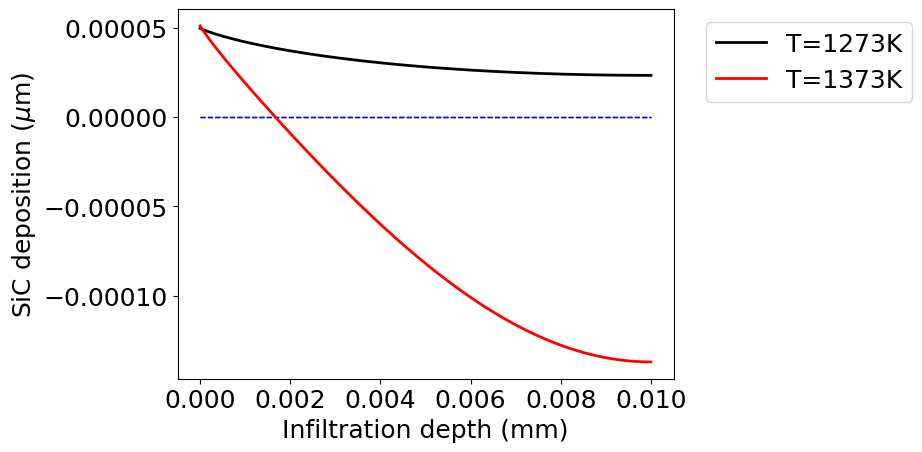

In [3]:
#
# Call the function cvi_sim
#

# Inputs: Temperature (K), pressure (Pa), pore diameter (m), aspect ratio, gas ratio,      ...
#         plot line color, plot line label, dt, variable to be plotted between "phi" or "C".



# cvi_sim_implicit(1223,20000,34e-6, 10e-3/34e-6, 5, "black","T=1273K",100,"phi")

# plt.figure()
# cvi_sim_implicit(1073,20000,100e-6, 100, 10, "blue","T=1073K",10000,"phi")
cvi_sim_implicit(1273,20000,100e-6, 100, 10, "black","T=1273K",100,"phi")
cvi_sim_implicit(1373,20000,100e-6, 100, 10, "red","T=1373K",100,"phi")


